# scVelo analysis

In [1]:
gpu=False

import scvelo as scv
import scanpy as sc
import anndata as ad
import os
from glob import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

if gpu:
    from velovi import preprocess_data, VELOVI
    import torch


In [2]:
scv.settings.set_figure_params("scvelo")

# Load and preprocess data

## Load data

In [3]:
data_path = '/lustre/groups/ml01/workspace/laura.martens/moretti_colab'
rna_path = os.path.join(data_path, 'scglue')
loom_path = os.path.join(data_path, 'transfer_data/loom/')
save_path = os.path.join(data_path, 'scvelo')

## Load raw data

In [38]:
loom_files = pd.Series(glob(os.path.join(loom_path, '*.loom')))

In [39]:
days = loom_files.str.split('Day|\.loom', regex=True, expand = True)[1]

In [40]:
day_sample_map = {'2': '1', '3': '2', '4': '3', '5': '4', '7': '5', '10': '6', '15': '7'}

In [41]:
rna = sc.read(os.path.join(rna_path, "rna_preprocessed.h5ad"))

In [42]:
adatas = []
for day, file in zip(days, loom_files):
    print(day)
    adata = scv.read(file, cache=True)
    adata.obs['day'] = day
    adata.obs.index = adata.obs.index.to_series().str.split(':|x', regex=True, expand=True)[1].values + '-1_' + adata.obs.day.map(day_sample_map).values
    
    #subset to rna cells and var
    adata = adata[adata.obs_names.isin(rna.obs_names), adata.var_names.isin(rna.var_names)].copy()
    #make var unique otherwise concat does not work
    adata.var_names_make_unique()
    adatas.append(adata)

4
2
5
10
3
7
15


### Preprocess data

In [43]:
adata = ad.concat(adatas, axis=0)

In [44]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)

Filtered out 14432 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [45]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [46]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [52]:
adata = adata[rna.obs_names].copy()

In [55]:
adata.obs['clusters'] = rna.obs['clusters']

In [57]:
adata.write(os.path.join(save_path, 'adata_u_s_processed.h5ad'))

# Read data

In [4]:
adata = sc.read(os.path.join(save_path, 'adata_u_s_processed.h5ad'))

In [5]:
#load metacells
metacells = sc.read('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/metacells.h5ad')

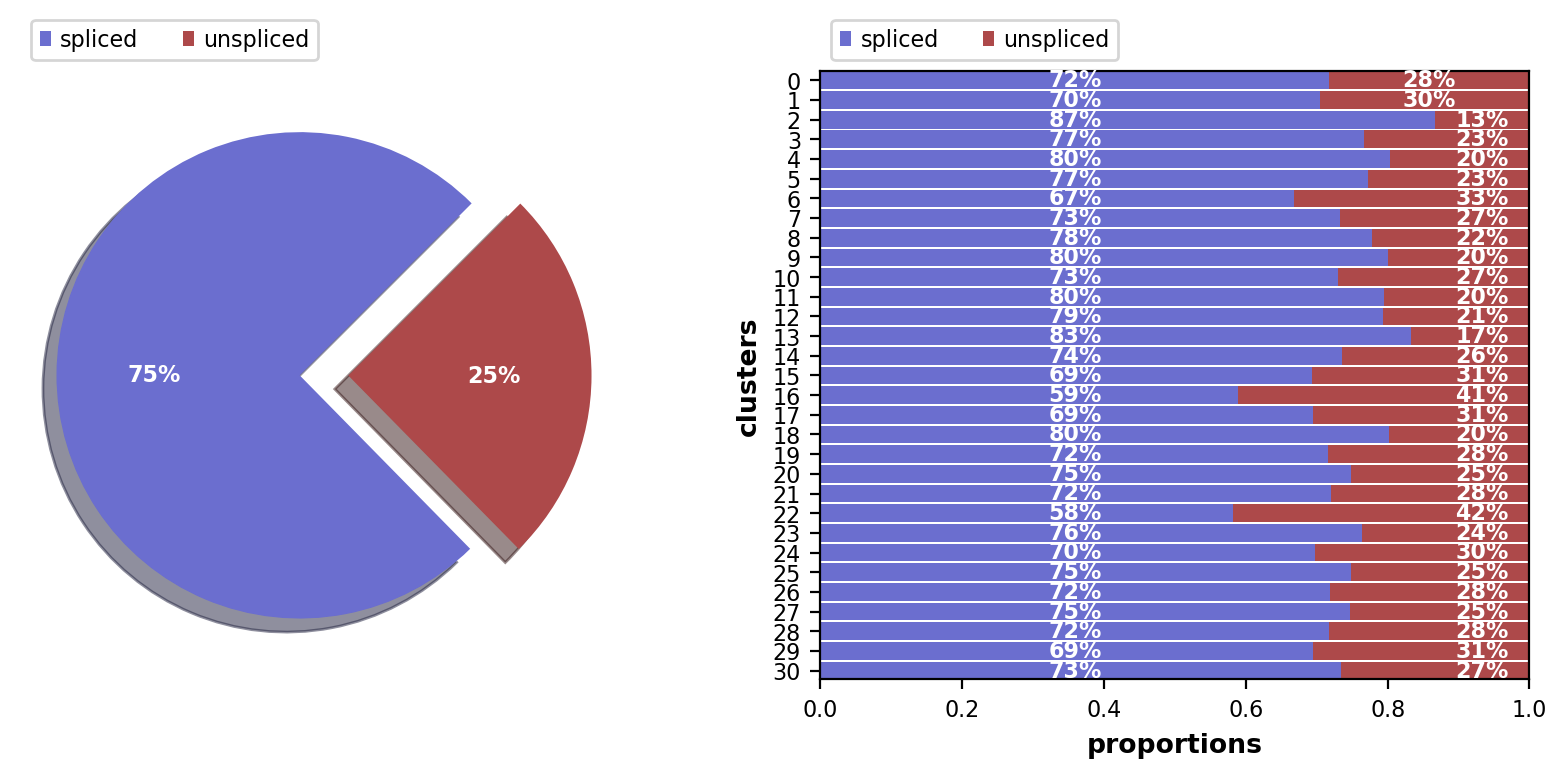

In [6]:
scv.pl.proportions(adata, figsize=(10,4))

# Scvelo model

In [9]:
scv.tl.recover_dynamics(adata, n_jobs=15)

recovering dynamics (using 15/96 cores)


  0%|          | 0/883 [00:00<?, ?gene/s]

    finished (0:23:38) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [10]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:37) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/96 cores)


  0%|          | 0/35499 [00:00<?, ?cells/s]

    finished (0:02:27) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [15]:
adata = adata[metacells.obs_names].copy()

In [16]:
adata.obsm['X_umap'] = metacells.obsm['X_umap']

computing velocity embedding
    finished (0:00:08) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


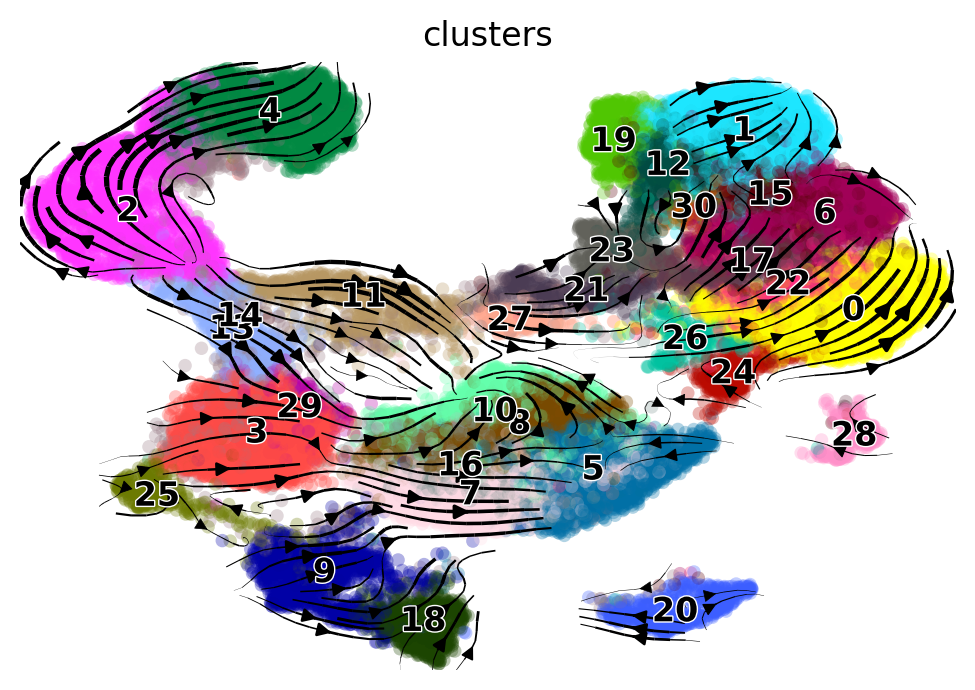

In [17]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

In [18]:
adata.write(os.path.join(save_path, 'scvelo_adata_non_dl.h5ad'))